# The Habitual DDPG Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that minimise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting


Okay so new idea! DDPG seems pretty good so far. How about we have the Q function take latent states as input and use the VAEs good latent features as input. Then we'll have
- Q(o, a)
- p(s|o) and p(o|s)
- p(s'|s, a)
- V(o) or U(o)



In [1]:
from util import random_observation_sequence, transform_observations
import matplotlib.pyplot as plt
import gym

from ddpg import *

/Users/Ethan/miniconda3/envs/tf_daif_car_race/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:61: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
env = gym.make('MountainCarContinuous-v0')

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  2
Size of Action Space ->  1
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
actor_model = get_actor(2, 1)
critic_model = get_critic(2, 1)

target_actor = get_actor(2, 1)
target_critic = get_critic(2, 1)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.0001
actor_lr = 0.00005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

# buffer = Buffer(50000, 64, 0.99, 2, 1, critic_optimizer, actor_optimizer)

ddpg = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [12]:
t_max = 1000
num_episodes = 50

min_reward_cutoff = -1000
min_reward_set = -0.5

reward_increase = 0

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    total_reward = 0

    o, a, r = random_observation_sequence(env, t_max, epsilon=0.2)
    o = transform_observations(o, observation_max, observation_min, [0, 0])
    # o = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # print(o)

    for i in range(len(a)):

        prev_state = o[i]
        state = o[i+1]
        action = a[i]
        reward = r[i] + reward_increase

        # if reward < 0:
        #     print("yes")

        total_reward += reward

        # ddpg.buffer.record((prev_state, action, reward, state))
        # # episodic_reward += reward
        #
        # ddpg.buffer.learn()

        ddpg.record((prev_state, action, reward, state))
        # episodic_reward += reward

        ddpg.train([], [], [], [])

    print(total_reward)

    acts = ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))
    print(np.max(acts), np.min(acts))


-33.04776346421558
1.0 0.99998903
74.11115526533595
1.0 0.9805884
-33.21363154655761
1.0 0.99988675
84.7942343750702
1.0 0.9774433
-35.26668935817751
1.0 0.9674082
-33.430041847754104
1.0 0.99990267
79.92642768907245
1.0 0.9904716
75.85511048259082
1.0 0.97927713
73.4471165287704
1.0 0.9999975
-32.6958885898863
1.0 0.99999976
-33.23100233740506
1.0 0.99997145
-29.60730057009701
1.0 0.99999976
74.55052192384022
1.0 0.9999251
85.72272065091403
1.0 0.9999638
77.83197901632163
1.0 0.99999964
92.95478341957659
1.0 0.9999687
-32.412052358214915
1.0 0.99999756
69.74323508267804
1.0 0.9999967
73.0468521197316
1.0 0.999998
-31.500069501794567
1.0 0.99999386
88.67837182234491
1.0 0.9999961
-30.16829582916364
1.0 0.99999976
91.92049156465663
1.0 0.99998665
91.64458096920055
1.0 0.99999976
-36.31846038803997
1.0 0.9999909
-29.64909740086122
1.0 0.99999976
83.31622014330962
1.0 0.99999976
77.24332674685584
1.0 0.99999917
90.12593465796877
1.0 0.99999976
-31.69247455211393
1.0 0.9999979
75.624641135

In [13]:
ddpg.critic_model([(np.random.random(size=(10, 2))*2 - 1), (np.random.random(size=(10, 1))*2 - 1)])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 838.5698 ],
       [ 532.83673],
       [ 775.032  ],
       [ 807.1837 ],
       [ 796.0321 ],
       [ 798.75635],
       [ 484.0688 ],
       [2515.2515 ],
       [ 623.87976],
       [ 579.2384 ]], dtype=float32)>

In [14]:
ddpg.actor_model((np.random.random(size=(10, 2))*2 - 1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.66189045],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99999976],
       [ 0.99956656],
       [-0.99893314],
       [-0.9954624 ],
       [-0.9723895 ],
       [-0.98310494],
       [ 1.        ]], dtype=float32)>

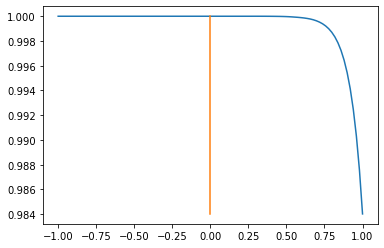

In [8]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = ddpg.actor_model(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999976]
 [0.99999

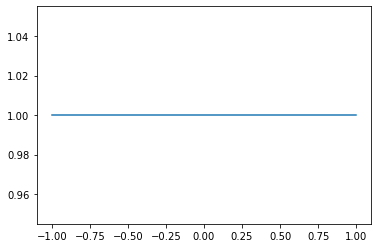

In [9]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = ddpg.actor_model(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [10]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        # action = act_net(obs) * 10
        # action = np.clip(action.numpy(), -1, 1)

        action = ddpg.actor_model(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")
        print("max obs", obs)

    print(np.sum(rewards))
    # print(rewards)




env.close()

/Users/Ethan/python_repos/gym/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/Ethan/python_repos/gym/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See

68
success
93.44974719718894
68
success
93.44670235530067
68
success
93.44526474662442
66
success
93.64958955736816
68
success
93.44829517462155



KeyboardInterrupt



In [10]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

NameError: name 'act_net' is not defined

In [ ]:
n = 50
coords = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
coords = np.array(coords)
coords


In [ ]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x,y)

X